In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from scipy.special import softmax

from sklearn.metrics import accuracy_score,f1_score,zero_one_loss,confusion_matrix,precision_score,plot_confusion_matrix

import tensorflow_probability as tfp
import numpy as np
import pandas as pd

In [2]:
# Data
df = pd.read_csv('../input/mnistdata/mnist.csv')
df.head()

,Unnamed: 0,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


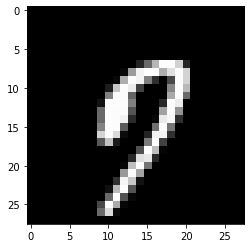

Label: 7


In [3]:
# pick a sample to plot
sample = np.random.randint(df.shape[0])
image = df.iloc[sample,2:].values.reshape(28,28)
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()
print('Label: '+str(df['label'].values[sample]))

4132

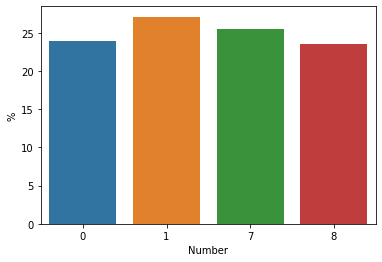

In [4]:
sns.barplot(x="label",y="label",data=df,
            estimator=lambda x: len(x) / len(df.label) * 100).set(ylabel="%",xlabel="Number")

sum(df.label.values==0)

Classes are balanced

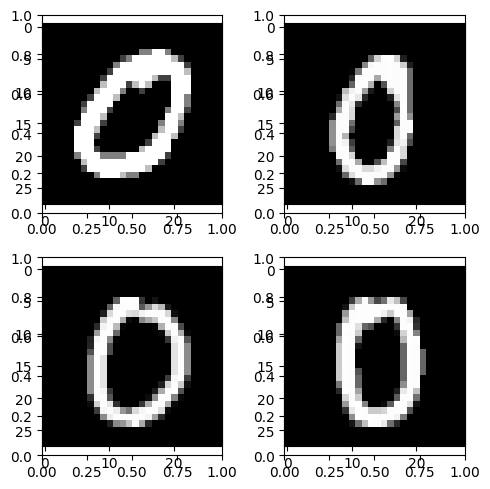

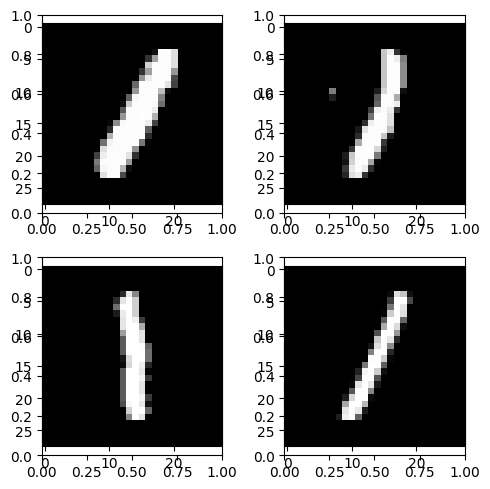

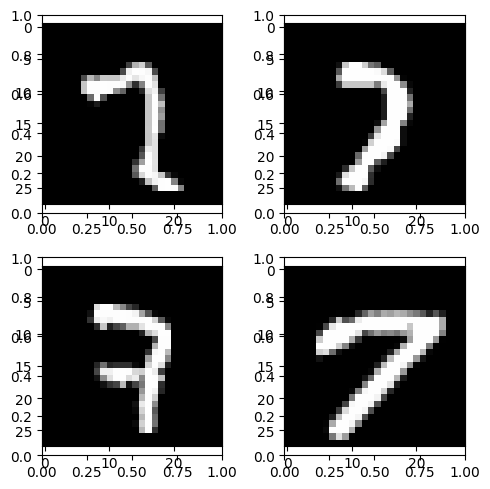

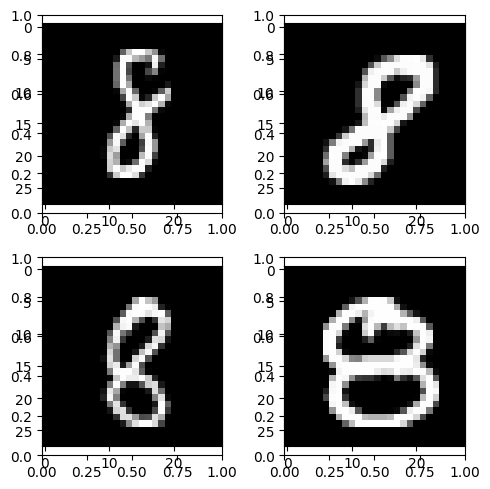

In [5]:
zeros = np.where(df.label.values==0)[0]
ones = np.where(df.label.values==1)[0]
sevens = np.where(df.label.values==7)[0]
eights = np.where(df.label.values==8)[0]


rows = 2
columns = 2

fig, ax = plt.subplots(rows, columns, figsize=(5,5), dpi=100)
fig.tight_layout()


for i in range(1, columns*rows +1):
    image = df.iloc[np.random.choice(zeros),2:].values.reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap='gray')

fig, ax = plt.subplots(rows, columns, figsize=(5,5), dpi=100)
fig.tight_layout()


for i in range(1, columns*rows +1):
    image = df.iloc[np.random.choice(ones),2:].values.reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap='gray')
    
fig, ax = plt.subplots(rows, columns, figsize=(5,5), dpi=100)
fig.tight_layout()


for i in range(1, columns*rows +1):
    image = df.iloc[np.random.choice(sevens),2:].values.reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap='gray')
    
    
fig, ax = plt.subplots(rows, columns, figsize=(5,5), dpi=100)
fig.tight_layout()


for i in range(1, columns*rows +1):
    image = df.iloc[np.random.choice(eights),2:].values.reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap='gray')
    
    
    
    
    

In [6]:
#Hold out a test set
from sklearn.model_selection import train_test_split
#X = df.iloc[:,:-1]
#y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,2:],df.iloc[:,1],random_state=0,test_size=0.25)

y_test_onehot = OneHotEncoder(sparse=False).fit_transform(y_test.values.reshape(-1,1))
y_train_onehot = OneHotEncoder(sparse=False).fit_transform(y_train.values.reshape(-1,1))

In [7]:
def scatter_2d_label_with_subset(X_2d, y,subset, ax=None, s=0.5, alpha=0.85, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
        
    subset : ndarray
        subset of points to be flagged on the plot
    """
    
    targets = np.unique(y)# extract unique labels
    colors = sns.color_palette(n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
        
    ax.scatter(X_2d[subset, 0],X_2d[subset, 1],color='black')
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

In [8]:
# PCA : Assesss variables' relevance
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.iloc[:,2:])
print('Variance explained by the '+str(n_components)+' first pca components: '+str(round(np.sum(pca.explained_variance_ratio_),2)))


y=df['label'].values.reshape(-1)
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_pca, y, ax=ax)
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');


NameError: name 'n_components' is not defined

### Baseline: logistic regression

In [ ]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)


y_pred=logreg.predict(X_test)

from sklearn.metrics import accuracy_score,f1_score,zero_one_loss,confusion_matrix,precision_score,plot_confusion_matrix
print('Accuracy on train set: '+str(accuracy_score(y_train,logreg.predict(X_train))))
print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred))+"\n")
#precision_score(y_test,y_pred)
#f1_score(y_test,y_pred)
#zero_one_loss(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))

plot_confusion_matrix(logreg,X_test,y_test)


In [ ]:
#Random Forest/Classification tree
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=100,max_leaf_nodes=950)
RFC.fit(X_train,y_train)


y_pred=RFC.predict(X_test)


from sklearn.metrics import accuracy_score,f1_score,zero_one_loss,confusion_matrix,precision_score,plot_confusion_matrix
print('Accuracy on train set: '+str(accuracy_score(y_train,RFC.predict(X_train))))
print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred))+"\n")
#precision_score(y_test,y_pred)
#f1_score(y_test,y_pred)
#zero_one_loss(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))

plot_confusion_matrix(RFC,X_test,y_test)


### Vanilla CNN

In [ ]:
#Convert quality to float
y_train=df.iloc[:,1].astype(float).values
y_test=y_train
X_train=df.iloc[:,2:]
X_test=X_train

#esc = StandardScaler()
#
#X_train = esc.fit_transform(X)
#X_test = X_train


from sklearn.preprocessing import OneHotEncoder
y_train_onehot = OneHotEncoder(sparse=False).fit_transform(y_train.reshape(-1,1)) 
y_test_onehot = y_train_onehot 


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

X_train_cnn = X_train.values.reshape(-1,28,28,1)
X_test_cnn = X_test.values.reshape(-1,28,28,1)

In [ ]:
cnn_vanilla_model = keras.Sequential(
    [
        layers.Conv2D(filters=32,
                      kernel_size = (6, 6),
                      input_shape = (28, 28,1),
                      padding='valid',
                      activation='relu',),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Conv2D(filters=32,
                      kernel_size = (6, 6),
                      input_shape = (28, 28, 1),
                      padding='valid',
                      activation='relu',),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(4, activation = 'softmax')
    ]
)

In [ ]:
n_epochs = 10
batch = 512
cnn_vanilla_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy',metrics=['accuracy'])
#model.fit(x=X, y=y, epochs=300, batch_size=batch, verbose = 0)
cnn_vanilla_history=cnn_vanilla_model.fit(X_train_cnn, y_train_onehot, batch_size=batch ,
                                  epochs=n_epochs,verbose=1,validation_data=(X_test_cnn,y_test_onehot))

In [ ]:
#print(vanilla_history.history.keys())
fig, ax = plt.subplots(1, 2, figsize=(5,2), dpi=150)

#"Loss"
sns.lineplot(x=1+np.arange(n_epochs), y=cnn_vanilla_history.history['loss'],ax=ax[0],color='blue')
sns.lineplot(x=1+np.arange(n_epochs), y=cnn_vanilla_history.history['val_loss'],ax=ax[0],color='orange')
ax[0].legend(['Training loss','Testing loss'],fontsize=8)
ax[0].set(xlabel='Epoch')

#"MSE"'
sns.lineplot(x=1+np.arange(n_epochs), y=cnn_vanilla_history.history['accuracy'],ax=ax[1],color='blue')
sns.lineplot(x=1+np.arange(n_epochs), y=cnn_vanilla_history.history['val_accuracy'],ax=ax[1],color='orange')
ax[1].legend(['Training accuracy','Testing accuracy'],fontsize=8)
ax[1].set(xlabel='Epoch')

In [ ]:
score = cnn_vanilla_model.evaluate(X_test_cnn, y_test_onehot, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
p = cnn_vanilla_model.predict(X_test_cnn)                    # Fitted values (outputs predicted from training inputs)
confusion_matrix(np.argmax(y_test_onehot, axis=1),  # Input class membership
                 np.argmax(p, axis=1))  # Output class membership

Let us see which digits the cnn struggles at when classifying

### Bayesian CNN (BCNN)

In [ ]:
#kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p))

from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Model, Sequential


def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))


def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

# Add a variable "weight" to the layer
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

In [ ]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(128, kernel_size=(2, 2), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(2, 2), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    conv_3 = Convolution2DFlipout(32, kernel_size=(2, 2), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_3 = add_kl_weight(conv_3, train_size)
    x = conv_3(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(4, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model


bcnn_model = build_bayesian_bcnn_model(X_train_cnn.shape[1:], X_train.shape[0])

def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_distr=tfp.distributions.OneHotCategorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_distr.log_prob(y_true))

def loss(y_true,y_pred,model=bcnn_model):
    nll = neg_log_likelihood_with_logits(y_true, y_pred)
    kl = tf.keras.losses.kullback_leibler_divergence(y_true, y_pred)
    
    return kl + nll
    
bcnn_model = build_bayesian_bcnn_model(X_train_cnn.shape[1:], X_train.shape[0])
bcnn_model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'],
                   experimental_run_tf_function=False)
bcnn_model.summary()



In [ ]:
n_epochs = 10
bcnn_history = bcnn_model.fit(X_train_cnn, y_train_onehot, batch_size=128,
                                 epochs=n_epochs, verbose=1,validation_data=(X_test_cnn,y_test_onehot))



MC sampling to approximate the posterior predictive distribution

In [ ]:
import tqdm
MC_samples = 100
y_pred_list = []
for i in tqdm.tqdm(range(MC_samples)):
    y_pred = softmax(bcnn_model.predict(X_test_cnn),axis=1)
    y_pred_list.append(y_pred)
    

In [ ]:
pred_mean = np.mean(y_pred_list,axis=0)
pred_median = np.median(y_pred_list,axis=0)
pred_sd = np.std(y_pred_list,axis=0)

from scipy.stats import median_abs_deviation
pred_mad = median_abs_deviation(y_pred_list,axis=0)

In [ ]:
#Another measure of uncertainty
NLL=-np.log(np.max(pred_mean,axis=1))

In [ ]:
def label(n):
    if n==2:
        return 7
    if n==3:
        return 8
    return n

mislabelling = []
only_one = []
more_than_one = []
none = []
n_classes=4
prediction = np.zeros((X_test.shape[0],n_classes))
threshold = 0.25 ## Set a threshold of 20%


for i in range(X_test.shape[0]):
    #indexes=[idx for idx in range(n_classes) if pred_median[i,idx]>= threshold]
    indexes=[idx for idx in range(n_classes) if pred_mean[i,idx]>= threshold]

    for c in range(n_classes):
        if pred_mean[i,c]> threshold:
            prediction[i,c] = 1
    
    if len(indexes)==1:
        only_one.append(i)
        if y_test[i]!=indexes[0]:
            mislabelling.append(i) 
    else:
        if len(indexes)==0:
            none.append(i)
        more_than_one.append(i)
        mislabelling.append(i)
        


In [ ]:
print('Threshold imposed: '+str(threshold)+"\n")
print('Percentage of unconfidently labelled samples (i.e. more than one outcome): ' 
      +str(round(100*len(more_than_one)/y_test.shape[0],2))+" %"+"  (There are "+str(len(more_than_one))+")"+"\n")
print('Percentage of non-labelled samples: ' +str(round(100*len(none)/y_test.shape[0],2))+" %"+"  (There are "+str(len(none))+")"+"\n")


print('------------------------------------------------'+"\n")

print('Accuracy on whole test set (naively): '+str(round(100*accuracy_score(np.argmax(pred_mean,axis=1),
                                                                            np.argmax(y_test_onehot,axis=1)),2))+" %"+"\n")

print('Accuracy on confidently labelled samples (i.e. only one outcome): ' 
      +str(round(100*accuracy_score(prediction.astype(int)[only_one,],y_test_onehot[only_one]),2))+" %"+"\n")

print('Accuracy on unconfidently labelled samples (i.e. more than one outcome, return the most probable): '+str(round(100*accuracy_score(np.argmax(pred_mean[more_than_one],axis=1),
               np.argmax(y_test_onehot[more_than_one],axis=1)),2))+" %"+"\n")


print('------------------------------------------------'+"\n")

print('Precision on whole test set (naively): '+str(round(100*precision_score(np.argmax(pred_mean,axis=1),
                                                                            np.argmax(y_test_onehot,axis=1),average='weighted'),2))+" %"+"\n")


print('Precision on confidently labelled samples (i.e. only one outcome): ' 
      +str(round(100*precision_score(prediction.astype(int)[only_one,],y_test_onehot[only_one],average='weighted'),2))+" %"+"\n")

print('Precision on unconfidently labelled samples (i.e. more than one outcome, return the most probable): '+str(round(100*precision_score(np.argmax(pred_mean[more_than_one],axis=1),
               np.argmax(y_test_onehot[more_than_one],axis=1),average='weighted'),2))+" %"+"\n")


In [ ]:
def plot_pred_hist(y_pred, sample , n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(20, 7)):
    pred_matrix = np.zeros((MC_samples,n_class))
    for i in range(MC_samples):
        pred_matrix[i,] = y_pred[i][sample,]
        
    
    print('\nmean of predicted probs = \n', np.mean(pred_matrix,axis=0))
    print('\nmedian of predicted probs = \n', np.median(pred_matrix,axis=0))
    print('\nstd of predicted probs = \n', np.std(pred_matrix,axis=0))
    print('True label: '+str(y_test[sample]))
    print('Mean standard deviation = '+str(round(np.mean(np.std(pred_matrix,axis=0)),2)))
    

    
    image = X_test.iloc[sample,:].values.reshape(28,28)
    # plot the sample
    figure = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()
    figsize=(20, 7)
    
    bins = np.logspace(-n_bins, 0, n_bins+1)
    n_subplot_cols = (n_class + 1) // n_subplot_rows
    fig, ax = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=figsize, dpi=100)
    
    
    for i in range(n_subplot_rows):
        for j in range(n_subplot_cols):
            idx = i * n_subplot_cols + j
            if idx < n_class:
                #ax[i, j].hist(pred_matrix[:,idx], bins)
                sns.histplot(pred_matrix[:,idx],ax=ax[i][j],bins=n_bins,legend=True)
                
                heights = [ax[i][j].patches[p].get_height() for p in range(len(ax[i][j].patches))]
                data_mean = pd.DataFrame({'x':[np.mean(pred_matrix[:,idx])]*2,
                                           'y':[0,1.25*np.max(heights)]})
                
                for _ in range(7):#Get a brighter straight line by plotting several times
                    sns.lineplot(data=data_mean,x='x',y='y', color='red',ax=ax[i][j],legend='auto')
                #ax[i, j].set_xscale('log')
                ax[i,j].legend(['Mean'])
                ax[i,j].set_xlabel(('Probability'))
                #ax[i, j].set_ylim([0, n_mc_run/5])
                ax[i, j].title.set_text("{} (Mean prob: {:.2f}) (std: {:.2f}) ({})".format(str(label(idx)),
                                                                               np.mean(pred_matrix[:,idx]),
                                                                               np.std(pred_matrix[:,idx]),
                                                                               str(np.mean(pred_matrix[:,idx]) >= 0.2)))
               
            else:
                ax[i, j].axis('off')
    fig.subplots_adjust(hspace=0.4)
    plt.show()

In [ ]:
plot_pred_hist(y_pred = y_pred_list,
              sample = 4887,
              n_class = 4,
              n_mc_run=MC_samples)

### Entropy

In [ ]:
n_classes = 4
y_mean = np.mean(y_pred_list,axis=0)
y_median = np.median(y_pred_list,axis=0)

S=np.zeros((X_test.shape[0],))
for i in range(X_test.shape[0]):
    for c in range(n_classes):
        if y_mean[i,c]==0:
            pass
        else:
            S[i] -= y_mean[i,c]*np.log(y_mean[i,c])

In [ ]:
def scatter_2d_label_with_subset(X_2d, y,subset, ax=None, s=0.5, alpha=0.85, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
        
    subset : ndarray
        subset of points to be flagged on the plot
    """
    
    targets = np.unique(y)# extract unique labels
    colors = sns.color_palette(n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
        
    ax.scatter(X_2d[subset, 0],X_2d[subset, 1],color='black')
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

In [ ]:
# PCA : Assesss variables' relevance
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)
print(pca.explained_variance_ratio_)
#pca.components_

y=y_test.reshape(-1)
fig, ax = plt.subplots()
#scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(S_vanilla)[:100])
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(-S)[:50])
#scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(-np.mean(pred_sd,axis=1))[:50])
#scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(NLL)[:50])



ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');

Again, high entropy seems to coincide with high uncertainty

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(X_test)

In [ ]:
#Outliers according to LOF
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=[4887])

In [ ]:
#Outliers according to LOF
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(clf.negative_outlier_factor_)[847:848])

### Have a look at unconfidently labelled samples

In [ ]:
sns.histplot(S,bins=30)

In [ ]:
sns.histplot(np.mean(pred_sd,axis=1),bins=30)

In [ ]:
sns.histplot(NLL,bins=30)

In [ ]:
#For instance
len([a for a in np.array(more_than_one) if a in np.argsort(-S)[:len(more_than_one)]])/len(more_than_one)

In [ ]:
len([a for a in np.array(more_than_one) if a in np.argsort(-np.mean(pred_sd,axis=1))[:len(more_than_one)]])/len(more_than_one)

In [ ]:
len([a for a in np.array(more_than_one) if a in np.argsort(-NLL)[:len(more_than_one)]])/len(more_than_one)

In [ ]:
n_samples = 10
pred_sd_mean = np.mean(pred_sd,axis=1)
sorted_S = np.argsort(-S)
for i in range(n_samples):
    fig, ax = plt.subplots(1,3,figsize=(6,2),dpi=100)

    fig.tight_layout()
    
    if i>X_test.shape[0]:
        continue
        
    idx = sorted_S[i]
    sns.heatmap(X_test.iloc[idx,].values.reshape(28,28),
                cmap='gray',xticklabels=False,yticklabels=False,cbar=False,ax=ax[0])
    #"{} (Median prob: {:.2f}) (std: {:.2f}) ({})
    
    ax[0].title.set_text("True label: {}".format(str(y_test[idx])))
    if i==0:
        ax[1].title.set_text('Posterior samples')
        ax[2].title.set_text('Predictive probability')
    
    #ax[1].title.set_text("Mean std: {}".format(str(pred_sd_mean[idx])))
    #ax[2].title.set_text("Output: {}".format(str(prediction[idx])))

    for prob_sample in y_pred_list:
        sns.barplot(x=[0,1,7,8], y=prob_sample[idx, :],
                    alpha=0.1,ax=ax[1])
    sns.barplot(x=[0,1,7,8], y=pred_mean[idx, :],ax=ax[2])
    fig.show()
    


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(X_test)


sorted_lof = np.argsort(clf.negative_outlier_factor_)
for i in range(n_samples):
    fig, ax = plt.subplots(1,3,figsize=(6,2),dpi=100)

    fig.tight_layout()
    
    if i>X_test.shape[0]:
        continue
        
    idx = sorted_lof[i]
    sns.heatmap(X_test.iloc[idx,].values.reshape(28,28),
                cmap='gray',xticklabels=False,yticklabels=False,cbar=False,ax=ax[0])
    #"{} (Median prob: {:.2f}) (std: {:.2f}) ({})
    
    ax[0].title.set_text("True label: {}".format(str(y_test[idx])))
    if i==0:
        ax[1].title.set_text('Posterior samples')
        ax[2].title.set_text('Predictive probability')
    
    #ax[1].title.set_text("Mean std: {}".format(str(pred_sd_mean[idx])))
    #ax[2].title.set_text("Output: {}".format(str(prediction[idx])))

    for prob_sample in y_pred_list:
        sns.barplot(x=[0,1,7,8], y=prob_sample[idx, :],
                    alpha=0.1,ax=ax[1])
    sns.barplot(x=[0,1,7,8], y=pred_mean[idx, :],ax=ax[2])
    fig.show()
    



In [ ]:
indexes_with_largest_S = np.argsort(-S)[:10]
samples_with_largest_S = df.iloc[indexes_with_largest_S,:]

In [ ]:
sns.barplot(x="label",y="label",data=samples_with_largest_S,
            estimator=lambda x: len(x) / len(samples_with_largest_S.label) * 100).set(ylabel="%",xlabel="Number")


In [ ]:
sns.barplot(x="label",y="label",data=samples_with_largest_S,
            estimator=lambda x: len(x) / len(samples_with_largest_S.label) * 100).set(ylabel="%",xlabel="Number")


In [ ]:
#Create random image
random_image = np.random.uniform(low=0,high=1,size=28*28).reshape(-1,28*28)[0]
random_image_cnn =random_image.reshape(-1,28,28,1)

In [ ]:
import tqdm
random_pred_list = []
for i in tqdm.tqdm(range(100)):
    y_pred = softmax(bcnn_model.predict(random_image_cnn))
    random_pred_list.append(y_pred)

In [ ]:
random_pred_mean =np.mean(random_pred_list,axis=0)
S_random = -np.sum([p*np.log(p) for p in random_pred_mean])
NLL_random = -np.log(np.max(random_pred_mean,axis=1))
sd_random = np.mean(np.std(random_pred_list,axis=0),axis=1)[0]

In [ ]:
sns.histplot(np.mean(pred_sd,axis=1),bins=30)
plt.plot(sd_random,0,'r*',markersize=20)

In [ ]:
sns.histplot(NLL,bins=30)
plt.plot(NLL_random,0,'r*',markersize=20)

In [ ]:
sns.histplot(S,bins=30)
plt.plot(S_random,0,'r*',markersize=20)

In [ ]:

fig, ax = plt.subplots(1,3)
fig.set_dpi(110)

sns.heatmap(random_image.reshape(28,28),
            cmap='gray',xticklabels=False,yticklabels=False,cbar=False,ax=ax[0])

for prob_sample in random_pred_list:
    sns.barplot(x=[0,1,7,8], y=prob_sample[0, :],
                alpha=0.1,ax=ax[1])
sns.barplot(x=[0,1,7,8], y=np.mean(random_pred_list,axis=0)[0],ax=ax[2])
    

fig.show()



### Accuracy as a function of the number of samples taken

In [ ]:
Var_sort = np.argsort(np.mean(pred_sd,axis=1))
S_sort = np.argsort(S)
nll_sort = np.argsort(NLL)
nof_sort = np.argsort(-clf.negative_outlier_factor_)

In [ ]:
N_max = X_test.shape[0]
acc_sd = []
acc_S = []
acc_nll = []
acc_nof = []
range_samples = []
for i in range(int(0.5*N_max),N_max):
    acc_sd.append(accuracy_score(np.argmax(pred_mean[Var_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[Var_sort[:i]],axis=1)))
    
    acc_S.append(accuracy_score(np.argmax(pred_mean[S_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[S_sort[:i]],axis=1)))
    
    acc_nll.append(accuracy_score(np.argmax(pred_mean[nll_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[nll_sort[:i]],axis=1)))
    
    acc_nof.append(accuracy_score(np.argmax(pred_mean[nof_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[nof_sort[:i]],axis=1)))
    range_samples.append(100*i/N_max)
    

In [ ]:
plt.plot(range_samples,acc_sd,'g')
plt.plot(range_samples,acc_S,'b')
plt.plot(range_samples,acc_nll,'r')
plt.plot(range_samples,acc_nof,'k')
plt.legend(['std','Entropy','NLL','Local Outlier Factor'])
plt.xlabel('Percentage of samples taken(sorted by ascending metric)')
plt.ylabel('Accuracy')